AIRCRAFT DAMAGE DETECTION
we will utilize feature extraction with a pre-trained VGG16 model to classify the damage from aircraft images. Additionally, we will use a pre-trained Transformer model to generate captions and summaries for the images.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#required libraries
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [3]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [4]:
#Pre-trained model
# ResNet, VGG (Image Classification):
#BLIP (Image Captioning and Summarization)
#Set the batch size,epochs
batch_size = 32
n_epochs = 100
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [5]:
#Extracting dataset from zip file
import tarfile
import urllib.request
import os
import shutil

# URL of the tar file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZjXM4RKxlBK9__ZjHBLl5A/aircraft-damage-dataset-v1.tar"

# Define the path to save the file
tar_filename = "aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted

# Download the tar file
urllib.request.urlretrieve(url, tar_filename)
print(f"Downloaded {tar_filename}. Extraction will begin now.")

# Check if the folder already exists
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing the existing folder.")
    
    # Remove the existing folder to avoid overwriting or duplication
    shutil.rmtree(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
with tarfile.open(tar_filename, "r") as tar_ref:
    tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filename} successfully.")


Downloaded aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing the existing folder.
Removed the existing folder: aircraft_damage_dataset_v1
Extracted aircraft_damage_dataset_v1.tar successfully.


In [6]:
import os
import tarfile

# Extract dataset
tar_path = "aircraft_damage_dataset_v1.tar"
extract_path = "aircraft_damage_dataset_v1"

if not os.path.exists(extract_path):  # Avoid extracting again
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(extract_path)
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [7]:
# Define directories for train, test, and validation splits
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')

# Verify paths exist
for dir_path in [train_dir, test_dir, valid_dir]:
    print(f"Checking {dir_path}: ", os.path.exists(dir_path))


Checking aircraft_damage_dataset_v1\train:  True
Checking aircraft_damage_dataset_v1\test:  True
Checking aircraft_damage_dataset_v1\valid:  True


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerators for validation and test sets
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)  
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  

# Ensure these variables are defined: valid_dir, test_dir, seed_value, batch_size, img_rows, img_cols
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    seed=seed_value,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)


Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [10]:
#Load the VGG16 model
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(img_rows, img_cols, 3))

In [11]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [13]:
#compile
model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset path
dataset_path = "aircraft_damage_dataset_v1"

# Define directories for train, test, and validation splits
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

# Check if directories exist
for dir_path in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"Error: The directory '{dir_path}' does not exist!")

# Image dimensions and batch size
img_rows, img_cols = 224, 224  # Change as needed
batch_size = 32
seed_value = 42

# Create ImageDataGenerators for preprocessing
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load train images
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    seed=seed_value,
    class_mode='binary',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Load validation images
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary'
)

# Load test images
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Typically, test data is not shuffled
)

print("Data loaded successfully!")

Found 300 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Data loaded successfully!


In [19]:
# Train the model and store the history
train_history = model.fit(
	train_generator,
	validation_data=valid_generator,
	epochs=n_epochs,
	batch_size=batch_size
)

# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history.history['loss'], label='Training Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/100


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
# Train the model and store the history
train_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Adjust as needed
    verbose=1
)

# Check available keys in history
print(train_history.history.keys())

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(5, 5))
plt.plot(train_history.history.get('accuracy', train_history.history.get('acc')), label='Training Accuracy', marker='o')
plt.plot(train_history.history.get('val_accuracy', train_history.history.get('val_acc')), label='Validation Accuracy', marker='s')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 64, 64, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6393 - loss: 0.6630
Test Loss: 0.6743
Test Accuracy: 0.5833


In [ ]:
#visualize the model predictions
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


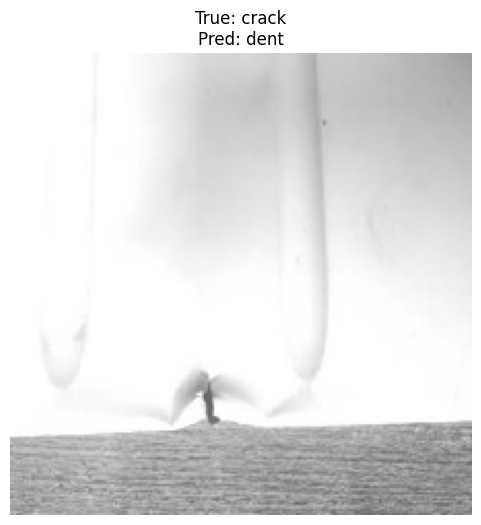

In [ ]:
# Define the index of the image to test
index_to_plot = 1  

# Test and visualize the model prediction
test_model_on_image(test_generator, model, index_to_plot=index_to_plot)


In [ ]:
%pip install torch transformers

In [ ]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [ ]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/repos/f1/cb/f1cbe4cfb2a267026632ce513d5918162e03df2ee28456145ba8a1d25cf39aad/90f4c493dfc6f4c2152c8bfcfd52ee141055feb835eea2dceb8b9231e5dbf17c?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1742829664&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjgyOTY2NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9mMS9jYi9mMWNiZTRjZmIyYTI2NzAyNjYzMmNlNTEzZDU5MTgxNjJlMDNkZjJlZTI4NDU2MTQ1YmE4YTFkMjVjZjM5YWFkLzkwZjRjNDkzZGZjNmY0YzIxNTJjOGJmY2ZkNTJlZTE0MTA1NWZlYjgzNWVlYTJkY2ViOGI5MjMxZTVkYmYxN2M%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=fvfwk7srjiZYIV-xI278AFpcoFUyHIqc6uk6lO6lWCPzivviBOGbHFC%7E%7E%7E2F23H8kJuduC7-K%7EqwRmjCO0C0KBRrmA9R3x-iH1UnFy4qS-7qZ0uGUsppJQ5s774mseeJQLNo8g6uSXJZfan4rQIiYOr2RXjgStuhl%7ELZrdl1E%7EbXROmGS7fV%7ETpKsKJi4qs5kvygLgMKeLuXnxGTCFPcjkSeyb3MOyOWky3KBpj2vQgoZCM1U6DXGcGllx8wl

In [ ]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


In [ ]:
# Define the generate_text function
def generate_text(image_path, task):
	"""
	Generate text (caption or summary) for a given image using the BLIP model.

	Args:
		image_path: TensorFlow constant containing the path to the image.
		task: TensorFlow constant specifying the task ("caption" or "summary").

	Returns:
		The generated text as a TensorFlow string.
	"""
	# Load the image using PIL
	image = Image.open(image_path.numpy().decode("utf-8")).convert("RGB")

	# Set the appropriate prompt based on the task
	if task.numpy().decode("utf-8") == "caption":
		prompt = "This is a picture of"
	else:
		prompt = "This is a detailed photo showing"

	# Prepare inputs for the BLIP model
	inputs = processor(images=image, text=prompt, return_tensors="pt")

	# Generate text output using the BLIP model
	output = model.generate(**inputs)

	# Decode the output into a readable string
	result = processor.decode(output[0], skip_special_tokens=True)
	return tf.constant(result)

# Path to an example image 
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


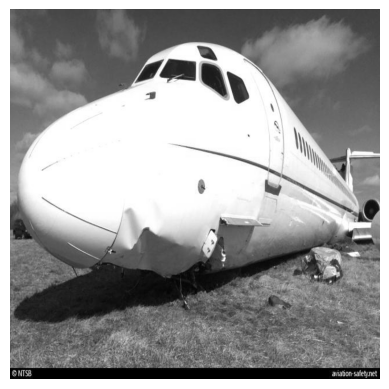

In [ ]:
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [ ]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image